In [ ]:
import kagglehub
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  Dropout, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

path = kagglehub.dataset_download("daniilonishchenko/mushrooms-images-classification-215")


100%|██████████| 1.55G/1.55G [00:39<00:00, 41.6MB/s]

Extracting files...


In [ ]:
import os

# The previous output was ['data'] from os.listdir(data_path).
# This means data_path contains another directory named 'data'.
# Let's go one level deeper to find the actual images.
image_root_path = os.path.join(path, 'data', 'data') # Changed data_path to path
print(f"Contents of {image_root_path}:")
print(os.listdir(image_root_path))

for msuhroom_type in os.listdir(image_root_path):
    print(f"Sample of {msuhroom_type}:")
    print(os.listdir(os.path.join(image_root_path, msuhroom_type))[:5])

Contents of /root/.cache/kagglehub/datasets/daniilonishchenko/mushrooms-images-classification-215/versions/2/data/data:
['earthballs', 'egghead_mottlegill', 'red_cracking_bolete', 'hairy_curtain_crust', 'oak_polypore', 'giant_funnel', 'poplar_fieldcap', 'cedarwood_waxcap', 'white_fibrecap', 'lurid_bolete', 'blushing_rosette', 'bovine_bolete', 'parrot_waxcap', 'white_dapperling', 'bitter_bolete', 'elfin_saddle', 'magpie_inkcap', 'porcelain_fungus', 'hen_of_the_woods', 'almond_mushroom', 'yellow_stagshorn', 'root_rot', 'pale_oyster', 'parasol', 'scarlet_caterpillarclub', 'blushing_wood_mushroom', 'horn_of_plenty', 'the_sickener', 'terracotta_hedgehog', 'horse_mushroom', 'winter_chanterelle', 'black_morel', 'splendid_waxcap', 'amanita_gemmata', 'bronze_bolete', 'dusky_puffball', 'black_bulgar', 'slimy_waxcap', 'bruising_webcap', 'smoky_bracket', 'poison_pie', 'shaggy_inkcap', 'oyster_mushroom', 'crimson_waxcap', 'saffron_milkcap', 'snakeskin_grisette', 'woolly_milkcap', 'bearded_milkcap',

In [ ]:
import os

class_names = os.listdir(image_root_path)
print(f"Number of mushroom classes found: {len(class_names)}")
print(f"First 5 class names: {class_names[:5]}")

Number of mushroom classes found: 215
First 5 class names: ['earthballs', 'egghead_mottlegill', 'red_cracking_bolete', 'hairy_curtain_crust', 'oak_polypore']


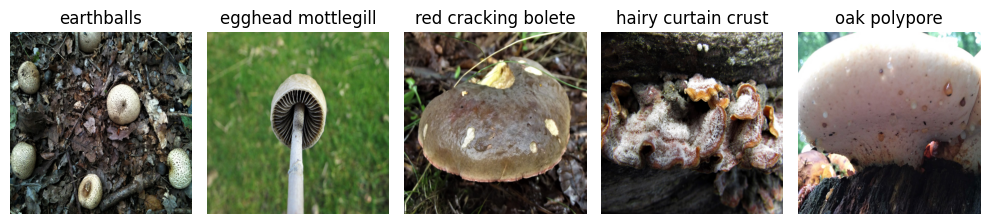

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Print first image from first 5 classes
plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names[:5]):
    class_path = os.path.join(image_root_path, class_name)
    # Get the first image file in the directory
    first_image_name = os.listdir(class_path)[0]
    first_image_path = os.path.join(class_path, first_image_name)

    # Load and display the image
    img = Image.open(first_image_path)
    plt.subplot(1, 5, i + 1) # Arrange plots in a 1x5 grid
    plt.imshow(img)
    plt.title(class_name.replace('_', ' '))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Loop through each category of mushroom and add 70% to train, 15% to val, 15% to test
train_data = []
test_data = []
val_data = []

for name in class_names:
    class_path = os.path.join(image_root_path, name)
    class_images = os.listdir(class_path)

    # First, split off the test set (15% of total)
    # The remaining (1 - 0.15 = 0.85) will be for train and val
    train_val_images, test_images = train_test_split(class_images, test_size=0.15, random_state=42)

    # Now, split the remaining images (train_val_images) into train (70% of total) and val (15% of total)
    # The proportion of val from train_val_images will be 0.15 / (1 - 0.15) = 0.15 / 0.85
    val_size_from_train_val = 0.15 / (1 - 0.15)
    train_images, val_images = train_test_split(train_val_images, test_size=val_size_from_train_val, random_state=42)

    train_data.extend([(os.path.join(class_path, img), name) for img in train_images])
    test_data.extend([(os.path.join(class_path, img), name) for img in test_images])
    val_data.extend([(os.path.join(class_path, img), name) for img in val_images])

In [ ]:
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Train samples: 1880
Validation samples: 619
Test samples: 623


# YOLOv8 goes here (Gavin)


In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.7 MB/s eta 0:00:00


In [ ]:
#resnet

In [ ]:
train_df = pd.DataFrame(train_data, columns=["filepath", "label"])
test_df = pd.DataFrame(test_data, columns=["filepath", "label"])

print("Train samples:", len(train_df))
print("Test samples :", len(test_df))
print(train_df.head())


Train samples: 1880
Test samples : 623
                                            filepath       label
0  /root/.cache/kagglehub/datasets/daniilonishche...  earthballs
1  /root/.cache/kagglehub/datasets/daniilonishche...  earthballs
2  /root/.cache/kagglehub/datasets/daniilonishche...  earthballs
3  /root/.cache/kagglehub/datasets/daniilonishche...  earthballs
4  /root/.cache/kagglehub/datasets/daniilonishche...  earthballs


In [ ]:
import os
import shutil
from ultralytics import YOLO

# Define the base directory for the YOLOv8 dataset
yolov8_dataset_dir = 'yolov8_mushroom_dataset'

# Create train and val directories
os.makedirs(os.path.join(yolov8_dataset_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(yolov8_dataset_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(yolov8_dataset_dir, 'test'), exist_ok=True)

# Function to prepare data into YOLOv8 classification format
def prepare_yolov8_classification_data(data_list, output_base_dir):
    for img_path, class_name in data_list:
        target_class_dir = os.path.join(output_base_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        shutil.copy(img_path, target_class_dir)

print("Preparing training data...")
prepare_yolov8_classification_data(train_data, os.path.join(yolov8_dataset_dir, 'train'))
print("Preparing validation data...")
prepare_yolov8_classification_data(val_data, os.path.join(yolov8_dataset_dir, 'val'))
print("Preparing test data...")
prepare_yolov8_classification_data(test_data, os.path.join(yolov8_dataset_dir, 'test'))

# Import yolov8 model
model = YOLO("yolov8s-cls.yaml").load("yolov8s-cls.pt")  # build from YAML and transfer weights

# Train the model, passing the base directory of the prepared dataset
print("Starting model training...")
results = model.train(data=yolov8_dataset_dir, epochs=50, imgsz=512, augment=True, hsv_h=0.05, hsv_s=.5, hsv_v=0.4, flipud=0.2, degrees=15.0, translate=0.2, scale=0.8)

# Evaluate on testing data and capture the results
print("Starting model validation...")
val_results = model.val(data=yolov8_dataset_dir, batch=64, imgsz=512, split='test')

# Graph the training loss and accuracy for both top1 and top5 over time
print("Starting model evaluation...")

Preparing training data...
Preparing validation data...
Preparing test data...
YOLOv8s-cls summary: 56 layers, 6,361,736 parameters, 6,361,736 gradients, 13.6 GFLOPs
Transferred 158/158 items from pretrained weights
Starting model training...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolov8_mushroom_dataset, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.2, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.05, hsv_s=0.5, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det

SyntaxError: '[31m[1msave_conf_mat[0m' is not a valid YOLO argument. Similar arguments are i.e. ['save_conf=False', 'save_json=False', 'save_crop=False'].

    Arguments received: ['yolo', '-f', '/root/.local/share/jupyter/runtime/kernel-6a874348-417e-4dd2-8d78-5736124c43ee.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ['segment', 'pose', 'classify', 'detect', 'obb']
                MODE (required) is one of ['predict', 'val', 'export', 'train', 'benchmark', 'track']
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolo11n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolo11n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolo11n.pt data=coco8.yaml batch=1 imgsz=640

    4. Export a YOLO11n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolo11n-cls.pt format=onnx imgsz=224,128

    5. Ultralytics solutions usage
        yolo solutions count or in ['crop', 'blur', 'workout', 'heatmap', 'isegment', 'visioneye', 'speed', 'queue', 'analytics', 'inference', 'trackzone'] source="path/to/video.mp4"

    6. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg
        yolo solutions help

    Docs: https://docs.ultralytics.com
    Solutions: https://docs.ultralytics.com/solutions/
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)

In [ ]:
val_results = model.val(data=yolov8_dataset_dir, batch=64, imgsz=512, split='test')


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,350,615 parameters, 0 gradients, 12.7 GFLOPs
train: /content/yolov8_mushroom_dataset/train... found 1880 images in 215 classes ✅ 
val: /content/yolov8_mushroom_dataset/val... found 619 images in 215 classes ✅ 
test: /content/yolov8_mushroom_dataset/test... found 623 images in 215 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 52.6±19.5 MB/s, size: 479.3 KB)
test: Scanning /content/yolov8_mushroom_dataset/test... 623 images, 0 corrupt: 100% ━━━━━━━━━━━━ 623/623 804.0Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 10/10 1.5s/it 14.9s
                   all        0.4      0.655
Speed: 2.1ms preprocess, 3.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val2


After the `model.val()` operation, the confusion matrix is typically saved as a `.png` file within your training run's directory. Based on the previous output, this directory is `/content/runs/classify/train2`. The following code will load and display that image:

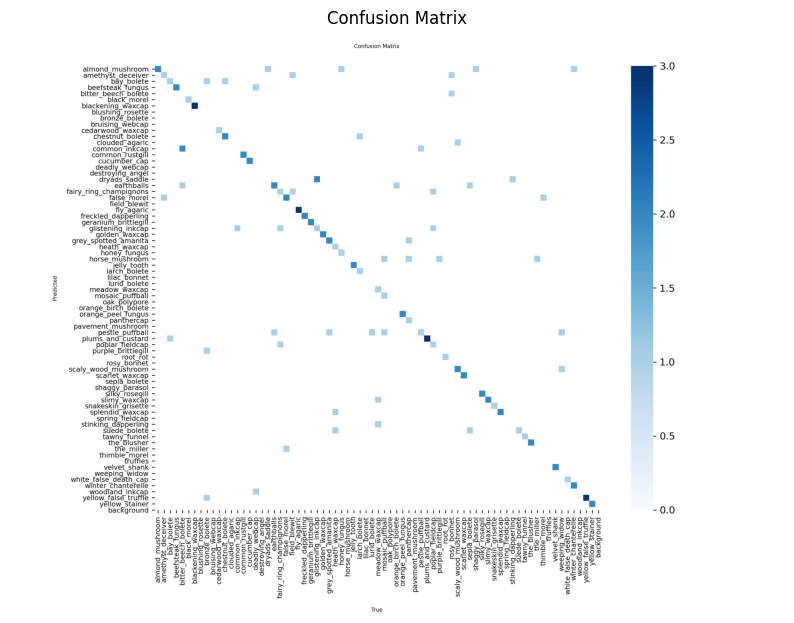

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# The training results were logged to '/content/runs/classify/train2'
confusion_matrix_path = os.path.join('/content/runs/classify/train2', 'confusion_matrix.png')

if os.path.exists(confusion_matrix_path):
    img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title('Confusion Matrix')
    plt.axis('off')
    plt.show()
else:
    print(f"Confusion matrix not found at {confusion_matrix_path}")

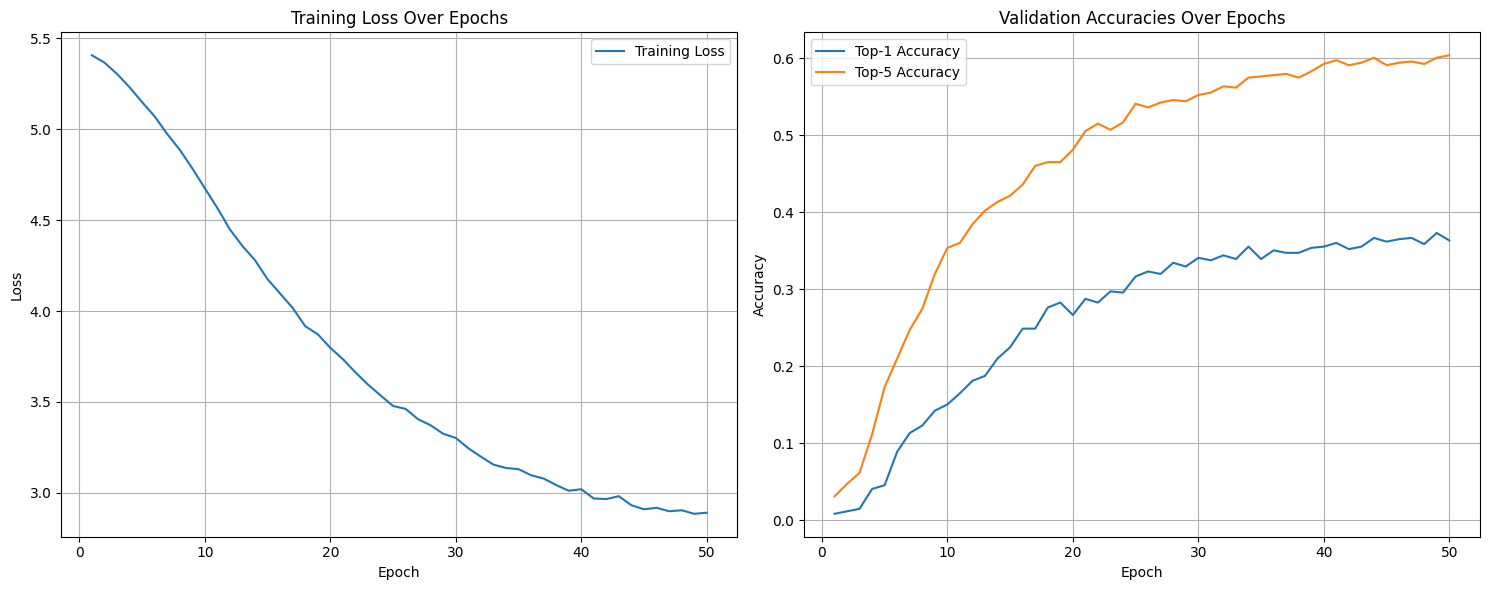

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# The training results are logged to the 'runs' directory
# Based on the previous output, the results are logged to '/content/runs/classify/train'
run_path = '/content/runs/classify/train'

results_path = os.path.join(run_path, 'results.csv')

if os.path.exists(results_path):
    # Read the results.csv file
    # Note: The first line of results.csv often contains headers starting with '# epoch', skip it.
    df_results = pd.read_csv(results_path, skipinitialspace=True)

    # Drop the first row if it contains NaN values after parsing, which can happen with comments/headers
    if df_results.iloc[0].isnull().all() and '# epoch' in df_results.columns:
        df_results = df_results.iloc[1:].copy()

    # Rename columns to remove leading '#' if present
    df_results.columns = [col.replace('# ', '') for col in df_results.columns]
    df_results = df_results.rename(columns={'epoch': 'epoch'})

    # Convert necessary columns to numeric
    for col in ['train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5']:
        if col in df_results.columns:
            df_results[col] = pd.to_numeric(df_results[col], errors='coerce')

    # Plotting
    plt.figure(figsize=(15, 6))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(df_results['epoch'], df_results['train/loss'], label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(df_results['epoch'], df_results['metrics/accuracy_top1'], label='Top-1 Accuracy')
    plt.plot(df_results['epoch'], df_results['metrics/accuracy_top5'], label='Top-5 Accuracy')
    plt.title('Validation Accuracies Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"results.csv not found at {results_path}. Please ensure training completed successfully.")

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# The training results were logged to '/content/runs/classify/train2'
confusion_matrix_path = os.path.join('/content/runs/classify/train2', 'confusion_matrix.png')

if os.path.exists(confusion_matrix_path):
    img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title('Confusion Matrix')
    plt.axis('off')
    plt.show()
else:
    print(f"Confusion matrix not found at {confusion_matrix_path}")


In [ ]:
# After the previous cell completes execution, 'val_results' will contain the evaluation metrics.
# Let's inspect the 'val_results' object to see what metrics are available.

print("\n--- Validation Metrics (from val_results object) ---")
if 'val_results' in locals() and hasattr(val_results, 'metrics'):
    print("Available metrics:")
    for k, v in val_results.metrics.items():
        print(f"  {k}: {v}")
elif 'val_results' in locals():
    print("val_results object does not have a 'metrics' attribute directly.")
    print("Inspecting other attributes:")
    for attr_name in dir(val_results):
        if not attr_name.startswith('_') and attr_name not in ['orig_img_path', 'names', 'save_dir', 'speed']:
            attr_value = getattr(val_results, attr_name)
            if not callable(attr_value):
                print(f"  {attr_name}: {attr_value}")
else:
    print("The 'val_results' variable is not yet available. Please ensure the previous cell has finished executing.")

print("\nFor classification tasks with YOLOv8, the primary metrics typically reported are Top-1 and Top-5 accuracy. F1-score and Recall are more often associated with object detection or segmentation tasks.")
print("If F1-score and Recall are crucial for your classification evaluation, you might need to:")
print("1. Ensure `save_conf_mat=True` is set in the `model.val()` call to generate a confusion matrix.")
print("2. Load the confusion matrix from the `runs` directory (e.g., `content/runs/classify/train/confusion_matrix.png` or similar data if available).")
print("3. Manually calculate precision, recall, and F1-score per class from the confusion matrix, and then compute micro, macro, or weighted averages as needed.")


--- Validation Metrics (from val_results object) ---
val_results object does not have a 'metrics' attribute directly.
Inspecting other attributes:
  confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79916b35d880>
  curves: []
  curves_results: []
  fitness: 0.5272873193025589
  keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
  results_dict: {'metrics/accuracy_top1': 0.3996789753437042, 'metrics/accuracy_top5': 0.6548956632614136, 'fitness': 0.5272873193025589}
  task: classify
  top1: 0.3996789753437042
  top5: 0.6548956632614136

For classification tasks with YOLOv8, the primary metrics typically reported are Top-1 and Top-5 accuracy. F1-score and Recall are more often associated with object detection or segmentation tasks.
If F1-score and Recall are crucial for your classification evaluation, you might need to:
1. Ensure `save_conf_mat=True` is set in the `model.val()` call to generate a confusion matrix.
2. Load the confusion matrix from the `runs` d